In [35]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [36]:
# Load the data
payment_header_df = pd.read_excel('Data/Payment Header.xlsx')

csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

In [37]:
print("Columns:", payment_header_df.columns.tolist())

Columns: ['CUSTOMER_NUMBER', 'DEPOSIT_REF']


In [38]:
print("Sample data:\n", payment_header_df.head())

Sample data:
   CUSTOMER_NUMBER DEPOSIT_REF
0          599000    DB04-153
1          599000    DB04-180
2          599000    DB05-036
3          599000    DB05-061
4          599000    DB05-118


In [39]:
print("Null values:\n", payment_header_df.isnull().sum())

Null values:
 CUSTOMER_NUMBER    0
DEPOSIT_REF        0
dtype: int64


In [40]:
# Remove rows with any null values
payment_header_df = payment_header_df.dropna()

In [41]:
print("Data shape:", payment_header_df.shape)

Data shape: (2631, 2)


In [42]:
payment_header_df

,CUSTOMER_NUMBER,DEPOSIT_REF
0,599000,DB04-153
1,599000,DB04-180
2,599000,DB05-036
3,599000,DB05-061
4,599000,DB05-118
...,...,...
2626,ZNAE01,DD09-013
2627,ZNAO01,DD04-005
2628,ZNAO01,DD08-014
2629,ZNAO01,DD09-014


In [43]:
# Define valid formats
valid_mask = payment_header_df['CUSTOMER_NUMBER'].str.match(r'^[A-Z]{4}([A-Z]{2}|[A-Z][0-9]|[0-9]{2})$', na=False)

# Filter valid entries
valid_customers_df = payment_header_df[valid_mask].copy()

In [44]:
valid_customers_df

,CUSTOMER_NUMBER,DEPOSIT_REF
49,AAMI01,DB09-026
50,ABHG01,DB06-176
51,ABHN01,DB08-195
52,ABHN02,DB09-181
53,ABRC01,DB05-041
...,...,...
2626,ZNAE01,DD09-013
2627,ZNAO01,DD04-005
2628,ZNAO01,DD08-014
2629,ZNAO01,DD09-014


## SEGMENTATION AND GROUPINGS

### Group by CUSTOMER_NUMBER and Number of Deposits

In [45]:
deposit_counts = valid_customers_df.groupby('CUSTOMER_NUMBER')['DEPOSIT_REF'].nunique().reset_index()
deposit_counts.rename(columns={'DEPOSIT_REF': 'NUM_DEPOSITS'}, inplace=True)

deposit_counts

,CUSTOMER_NUMBER,NUM_DEPOSITS
0,AAMI01,1
1,ABHG01,1
2,ABHN01,1
3,ABHN02,1
4,ABRC01,2
...,...,...
840,ZDOE01,4
841,ZHAY02,2
842,ZMAU01,1
843,ZNAE01,7


### Segment Customers by Deposit Volume

In [46]:
def segment_customer(n):
    if n == 1:
        return 'Single Deposit'
    elif n <= 5:
        return 'Low Activity (2–5)'
    elif n <= 10:
        return 'Moderate Activity (6–10)'
    else:
        return 'High Activity (>10)'

deposit_counts['SEGMENT'] = deposit_counts['NUM_DEPOSITS'].apply(segment_customer)

deposit_counts

,CUSTOMER_NUMBER,NUM_DEPOSITS,SEGMENT
0,AAMI01,1,Single Deposit
1,ABHG01,1,Single Deposit
2,ABHN01,1,Single Deposit
3,ABHN02,1,Single Deposit
4,ABRC01,2,Low Activity (2–5)
...,...,...,...
840,ZDOE01,4,Low Activity (2–5)
841,ZHAY02,2,Low Activity (2–5)
842,ZMAU01,1,Single Deposit
843,ZNAE01,7,Moderate Activity (6–10)


In [47]:
valid_customers_df.to_csv(os.path.join(csv_folder, "payment_headers_clean.csv"), index=False)
valid_customers_df.to_json(os.path.join(json_folder, "payment_headers_clean.json"), orient="records", lines=True)

## VISUALIZATION

### Distribution of Deposit Counts

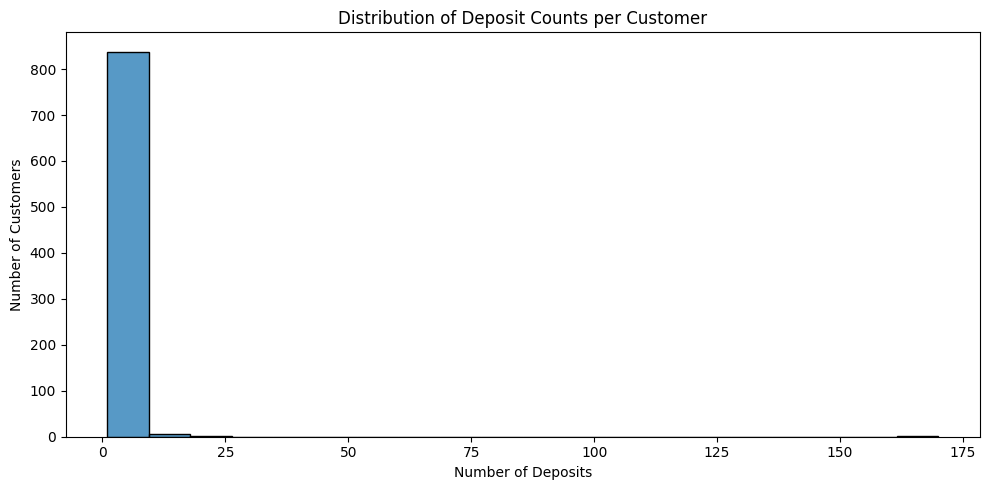

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(deposit_counts['NUM_DEPOSITS'], bins=20, kde=False)
plt.title('Distribution of Deposit Counts per Customer')
plt.xlabel('Number of Deposits')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

## Segment Breakdown

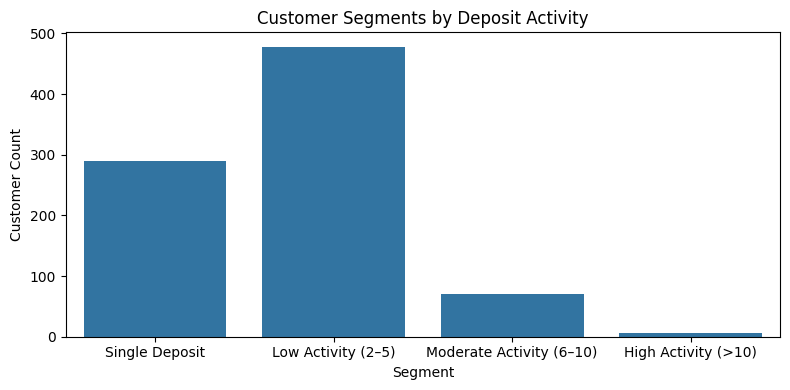

In [49]:
plt.figure(figsize=(8, 4))
sns.countplot(data=deposit_counts, x='SEGMENT', order=['Single Deposit', 'Low Activity (2–5)', 'Moderate Activity (6–10)', 'High Activity (>10)'])
plt.title('Customer Segments by Deposit Activity')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

## Top Customers by Deposit Volume

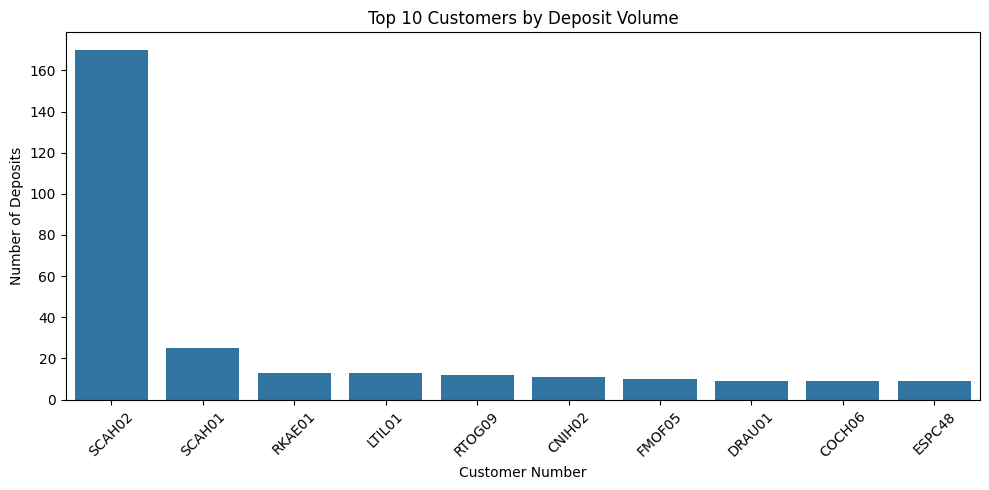

In [50]:
top_customers = deposit_counts.sort_values('NUM_DEPOSITS', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_customers, x='CUSTOMER_NUMBER', y='NUM_DEPOSITS')
plt.title('Top 10 Customers by Deposit Volume')
plt.xlabel('Customer Number')
plt.ylabel('Number of Deposits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()